In [9]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Deep Learning Analysis

In [10]:
import json
import joblib
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchmetrics import MeanSquaredError
from torchvision import datasets
from utils.helper_classes import CancerDataModule, CancerDataset
from utils.models import BaseCancerRegressor, CancerDataAutoEncoder

In [11]:
cancer_df = pd.read_csv("../data/cleaned_feature_and_target_data_large.csv", index_col=0)
cna_columns = [col for col in cancer_df.columns if col.startswith("CNA")]
numeric_cols = ["SMOKING_PACK_YEARS"] + cna_columns
cancer_df[numeric_cols] = cancer_df[numeric_cols].astype(np.float32)
scaler = joblib.load(open("results/scaler.pkl", "rb"))
cancer_dm = CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler)
cancer_dm.setup()

/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/jt_bmi_6114_cpu/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [12]:
cdm = CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler, scale_targets=True)
cdm.setup()
target_scaler = cdm.target_scaler

In [13]:
import random


class NNRegressor(L.LightningModule):
    def __init__(self, input_dim, n_layers=1, dropout=0.2, activation=nn.LeakyReLU, optimizer=torch.optim.Adam, lr=1e-3, weight_decay=1e-4, target_scaler=None):
        super(NNRegressor, self).__init__()
        self.target_scaler = target_scaler
        self.optimizer = optimizer
        self.lr = lr
        self.weight_decay = weight_decay
        self.layers = []
        curr_size = input_dim
        len_first_half = int(n_layers / 2)
        len_second_half = n_layers - len_first_half
        for i in range(len_first_half):
            new_size = curr_size * 2
            self.layers += [
                nn.Linear(curr_size, new_size),
                nn.BatchNorm1d(new_size),
                activation(),
                nn.Dropout(dropout),
            ]
            curr_size = new_size
        
        for i in range(len_second_half):
            new_size = curr_size // 2
            self.layers += [
                nn.Linear(curr_size, new_size),
                nn.BatchNorm1d(new_size),
                activation(),
                nn.Dropout(dropout),
            ]
            curr_size = new_size
        if curr_size > 1:
            self.layers.append(nn.Linear(curr_size, 1))
        self.network = nn.Sequential(*self.layers)

        self.loss_metric = MeanSquaredError()
        self.val_metric = MeanSquaredError()
        self.test_metric = MeanSquaredError()



    def forward(self, x):
        y = self.network(x)
        return y
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(self.device)
        y = y.to(self.device)
        y_hat = self(x)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_mse", self.loss_metric(y_hat, y), prog_bar=True)

        return loss
    
    def on_training_epoch_end(self):
        self.log("train_mse", self.loss_metric.compute())
        self.loss_metric.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_mse", self.val_metric(y_hat, y), prog_bar=True)

    def on_validation_epoch_end(self):
        self.log("val_mse", self.val_metric.compute())
        self.val_metric.reset()
        
    def configure_optimizers(self):
        return self.optimizer(self.network.parameters(), lr=self.lr, weight_decay=self.weight_decay)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_mse", self.test_metric(y_hat, y), prog_bar=True)
        return loss
    
    def on_test_epoch_end(self):
        self.log("test_mse", self.test_metric.compute())
        self.test_metric.reset()

simple_nn = NNRegressor(
    input_dim=len(cancer_dm.ds_train[0][0]),
    n_layers=8,
    target_scaler=target_scaler,
)

In [14]:
from torchinfo import summary

input_dim = len(cancer_dm.ds_train[0][0])
summary(NNRegressor(
    input_dim=len(cancer_dm.ds_train[0][0]),
    n_layers=8,
    target_scaler=target_scaler,
), input_size=(1, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
NNRegressor                              [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 1978]                 1,958,220
│    └─BatchNorm1d: 2-2                  [1, 1978]                 3,956
│    └─LeakyReLU: 2-3                    [1, 1978]                 --
│    └─Dropout: 2-4                      [1, 1978]                 --
│    └─Linear: 2-5                       [1, 3956]                 7,828,924
│    └─BatchNorm1d: 2-6                  [1, 3956]                 7,912
│    └─LeakyReLU: 2-7                    [1, 3956]                 --
│    └─Dropout: 2-8                      [1, 3956]                 --
│    └─Linear: 2-9                       [1, 7912]                 31,307,784
│    └─BatchNorm1d: 2-10                 [1, 7912]                 15,824
│    └─LeakyReLU: 2-11                   [1, 7912]   

In [15]:
from utils.helper_functions import create_classifier_trainer

trainer, regressor_csv_logger, regressor_checkpoint = create_classifier_trainer("cancer_regressor")
cancer_regressor = NNRegressor(
    input_dim=len(cancer_dm.ds_train[0][0]),
    n_layers=2,
    target_scaler=target_scaler,
)
trainer.fit(
    cancer_regressor,
    datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler, target_scaler=target_scaler),
)

/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/jt_bmi_6114_cpu/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 3.9 M  | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
3.9 M     Trainable params
0         Non-trainable params
3.9 M     Total params
15.689    Total estimated mod

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [16]:
trainer.test(
    model=cancer_regressor,
    datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler, target_scaler=target_scaler),
)

/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/jt_bmi_6114_cpu/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     2.431920051574707     │
│         test_mse          │     2.431920051574707     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.431920051574707, 'test_mse': 2.431920051574707}]

/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/jt_bmi_6114_cpu/lib/python3.12/site-packages/sklearn/preprocessing/_function_transformer.py:387: RuntimeWarning: overflow encountered in expm1
  return func(X, **(kw_args if kw_args else {}))


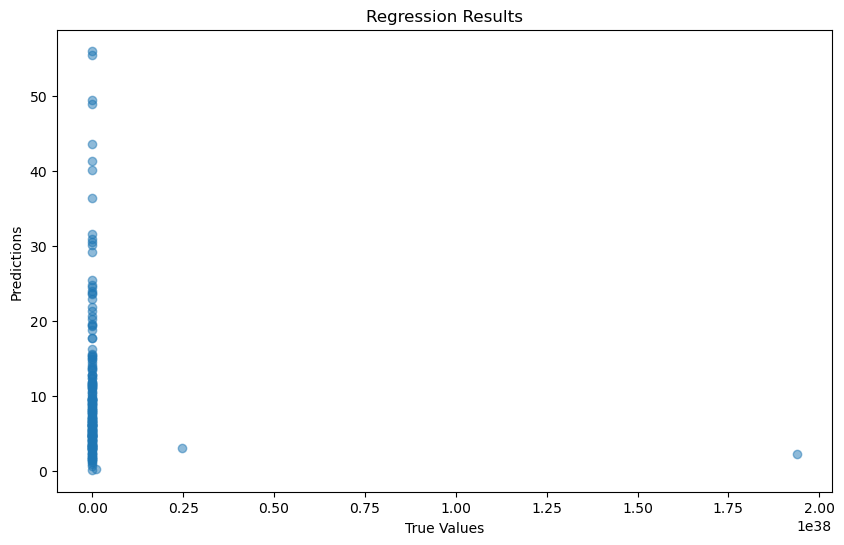

In [17]:
def plot_regression_results(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in dataloader:
            x, y = batch
            y_hat = torch.tensor(model.target_scaler.inverse_transform(model(x).numpy()))
            y_true.append(torch.tensor(model.target_scaler.inverse_transform(y.numpy())))
            y_pred.append(y_hat)

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Regression Results')
    plt.show()
plot_regression_results(cancer_regressor, cancer_dm.test_dataloader())

In [18]:
import optuna

trial_to_details = {}
def objective(trial):
    # Sample hyperparameters
    activation_dict = {
        "relu": nn.ReLU,
        "leaky_relu": nn.LeakyReLU,
        "tanh": nn.Tanh,
        "RReLU": nn.RReLU,
    }
    optimizer_dict = {
        "adam": torch.optim.Adam,
        "sgd": torch.optim.SGD,
        "adagrad": torch.optim.Adagrad,
    }
    n_layers = trial.suggest_int("n_layers", 3, 5)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)
    optimizer = trial.suggest_categorical("optimizer", list(optimizer_dict.keys()))
    activation = trial.suggest_categorical("activation", list(activation_dict.keys()) )

    activation = activation_dict[activation]
    optimizer = optimizer_dict[optimizer]

    model =NNRegressor(
        input_dim=len(cancer_dm.ds_train[0][0]),
        n_layers=n_layers,
        dropout=dropout,
        activation=activation,
        optimizer=optimizer,
        lr=learning_rate,
        weight_decay=weight_decay,
        target_scaler=target_scaler,
    )
    trainer, logger, checkpoint = create_classifier_trainer(f"nn_trial_{trial.number}", max_epochs=50, enable_pbar=False)


    # Training loop
    trainer.fit(
        model,
        datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler, target_scaler=target_scaler),
    )
    trial_to_details[trial.number] = {
        "logger" : logger,
        "checkpoint" : checkpoint,
    }

    
    # Store trial details
    trial_to_details[trial.number] = {
        "logger" : logger,
        "checkpoint" : checkpoint,
    }
    metrics_path = f"{logger.log_dir}/metrics.csv"
    metrics_df = pd.read_csv(metrics_path)

    if "val_mse" not in metrics_df.columns:
        return float("inf")

    last_val = metrics_df["val_mse"].dropna().values[-1]
    return last_val

In [19]:
# --- Run Optuna ---
study = optuna.create_study(direction="minimize", study_name="deep_regressor_scaled_study")
study.optimize(objective, n_trials=20, n_jobs=1, show_progress_bar=True)

# --- Print Best Result ---
print("Best trial:")
print(f"  Value (val_mse): {study.best_trial.value}")
print("  Params:")
for key, val in study.best_trial.params.items():
    print(f"    {key}: {val}")

[I 2025-04-18 13:50:05,363] A new study created in memory with name: deep_regressor_scaled_study


  0%|          | 0/20 [00:00<?, ?it/s]

/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/jt_bmi_6114_cpu/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 4.4 M  | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.648    Total estimated mod

[W 2025-04-18 14:33:19,382] Trial 0 failed with parameters: {'n_layers': 3, 'dropout': 0.11049060746482076, 'learning_rate': 0.00011534689422516221, 'weight_decay': 2.4278925743129923e-05, 'optimizer': 'adam', 'activation': 'RReLU'} because of the following error: NameError("name 'exit' is not defined").
Traceback (most recent call last):
  File "/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/jt_bmi_6114_cpu/lib/python3.12/site-packages/lightning/pytorch/trainer/call.py", line 48, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/jt_bmi_6114_cpu/lib/python3.12/site-packages/lightning/pytorch/trainer/trainer.py", line 599, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/jt_bmi_6114_cpu/lib/python3.12/site-packages/lightning/pytorch/trainer/trainer.py

NameError: name 'exit' is not defined

In [ ]:
activation_dict = {
    "relu": nn.ReLU,
    "leaky_relu": nn.LeakyReLU,
    "tanh": nn.Tanh,
    "RReLU": nn.RReLU,
}
optimizer_dict = {
    "adam": torch.optim.Adam,
    "sgd": torch.optim.SGD,
    "adagrad": torch.optim.Adagrad,
}
best_model = model =NNRegressor(
        input_dim=len(cancer_dm.ds_train[0][0]),
        n_layers=study.best_trial.params["n_layers"],
        dropout=study.best_trial.params["dropout"],
        activation=activation_dict[study.best_trial.params["activation"]],
        optimizer=optimizer_dict[study.best_trial.params["optimizer"]],
        lr=study.best_trial.params["learning_rate"],
        weight_decay=study.best_trial.params["weight_decay"],
        target_scaler=target_scaler,
    )

In [ ]:
joblib.dump(
    best_model,
    f"results/06/best_model_trial_noae_{study.best_trial.number}.pkl",
)

['results/06/best_model_trial_noae_3.pkl']

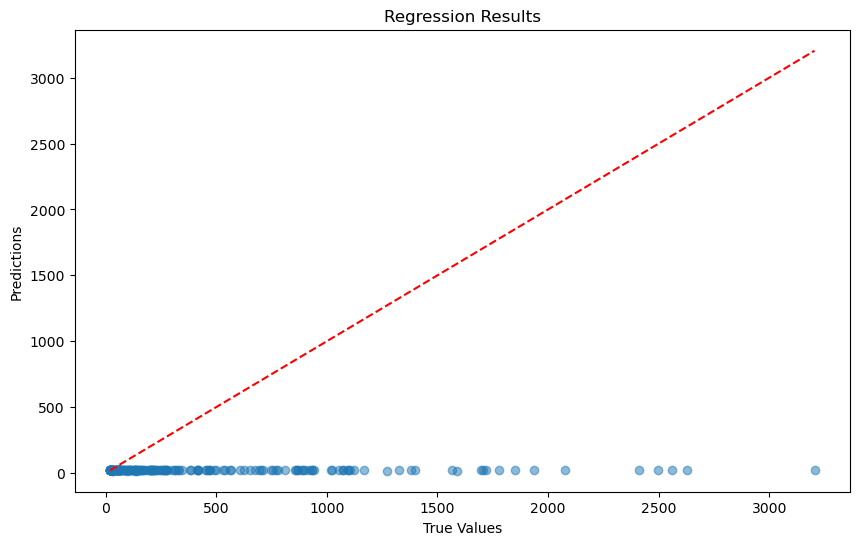

In [ ]:
plot_regression_results(best_model, cancer_dm.test_dataloader())